In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import joblib



In [4]:
# 1. 지역별 파일 딕셔너리
region_files = {
    'Uljin': ['./finalData/Uljin_04.csv', './finalData/Uljin_05.csv'],
    'Yeosu': ['./finalData/Yeosu_04.csv', './finalData/Yeosu_05.csv'],
    'InCheon': ['./finalData/InCheon_04.csv', './finalData/InCheon_05.csv'],
    'Taean': ['./finalData/Taean_04.csv', './finalData/Taean_05.csv'],
    'TongYeong': ['./finalData/TongYeong_04.csv', './finalData/TongYeong_05.csv']
}



In [5]:
# 2. 결과 저장용 리스트
results = []

for region, file_list in region_files.items():
    print(f'\n=== {region} 모델 학습 시작 ===')
    df_all = pd.concat([pd.read_csv(f) for f in file_list], ignore_index=True)
    print("전체 컬럼:", df_all.columns.tolist())

    # 3. 지역별 입력 컬럼 자동 선택
    required_cols = ['salt', 'wind_dir', 'temp', 'sea_dir_s', 'sea_dir_i', 'sea_temp']
    X_cols = [col for col in required_cols if col in df_all.columns]
    print(f"[{region}] 입력컬럼:", X_cols)
    X = df_all[X_cols].copy()
    y = df_all[['sea_high', 'wind_speed', 'pressure', 'sea_speed']]

    # 4. 방향컬럼 라벨 인코딩
    encoders = {}
    for col in ['wind_dir', 'sea_dir_i', 'sea_dir_s']:
        if col in X.columns:
            X[col] = X[col].fillna('Unknown').astype(str)
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col])
            encoders[col] = le

    # 5. train/val 분할
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # 6. 정규화
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # 7. 딥러닝 모델 설계
    model = Sequential([
        Dense(128, input_shape=(X_train_scaled.shape[1],), activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(4, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # 8. 학습
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model.fit(
        X_train_scaled, y_train,
        epochs=100,
        batch_size=32,
        validation_data=(X_val_scaled, y_val),
        callbacks=[early_stop],
        verbose=2
    )

    # 9. 결과 저장
    y_val_pred = model.predict(X_val_scaled)
    print(f"\n=== {region} 검증 데이터 성능 ===")
    mae = mean_absolute_error(y_val, y_val_pred)
    mse = mean_squared_error(y_val, y_val_pred)
    print("평균절대오차(MAE):", mae)
    print("평균제곱오차(MSE):", mse)

    for i, col in enumerate(y.columns):
        t_mae = mean_absolute_error(y_val[col], y_val_pred[:, i])
        t_avg = y_val[col].mean()
        t_ratio = t_mae / t_avg * 100 if t_avg != 0 else 0
        print(f"{col}: 평균={t_avg:.2f}, MAE={t_mae:.2f}, 상대오차={t_ratio:.2f}%")
        results.append({
            'region': region,
            'target': col,
            'MAE': t_mae,
            'MSE': mean_squared_error(y_val[col], y_val_pred[:, i]),
            'avg': t_avg,
            '비율(%)': t_ratio
        })

    # 10. 모델, 스케일러, 인코더 저장
    model.save(f'{region}_model.keras')
    joblib.dump(scaler, f'{region}_scaler.pkl')
    joblib.dump(encoders, f'{region}_encoders.pkl')
    print(f"\n✅ [{region}] 모델/스케일러/인코더 저장 완료")

# 11. 전체 지역별 결과 한 번에 보기
results_df = pd.DataFrame(results)
print("\n=== 전체 지역별 결과 테이블 ===")
print(results_df)
results_df.to_csv('all_region_results.csv', index=False)


=== Uljin 모델 학습 시작 ===
전체 컬럼: ['datetime', 'sea_high', 'salt', 'wind_speed', 'wind_dir', 'temp', 'pressure', 'sea_speed', 'sea_dir_s', 'sea_dir_i', 'sea_temp', 'can_sail']
[Uljin] 입력컬럼: ['salt', 'wind_dir', 'temp', 'sea_dir_s', 'sea_dir_i', 'sea_temp']
Epoch 1/100
220/220 - 2s - loss: 254827.7656 - mae: 261.3046 - val_loss: 254048.0938 - val_mae: 260.2432 - 2s/epoch - 9ms/step
Epoch 2/100
220/220 - 0s - loss: 251365.5156 - mae: 257.6098 - val_loss: 248771.0938 - val_mae: 254.8392 - 429ms/epoch - 2ms/step
Epoch 3/100
220/220 - 0s - loss: 243969.3125 - mae: 251.5470 - val_loss: 239395.1562 - val_mae: 248.5507 - 421ms/epoch - 2ms/step
Epoch 4/100
220/220 - 0s - loss: 233181.2969 - mae: 245.5661 - val_loss: 227064.0781 - val_mae: 242.1292 - 437ms/epoch - 2ms/step
Epoch 5/100
220/220 - 0s - loss: 219439.6719 - mae: 238.2469 - val_loss: 212040.7812 - val_mae: 234.0384 - 429ms/epoch - 2ms/step
Epoch 6/100
220/220 - 0s - loss: 203719.8906 - mae: 229.6100 - val_loss: 195377.4844 - val_mae: 224

KeyboardInterrupt: 

Epoch 1/200
135/135 [==============================] - 1s 4ms/step - loss: 0.8806 - val_loss: 1.3969
Epoch 2/200
135/135 [==============================] - 0s 2ms/step - loss: 0.7396 - val_loss: 1.4372
Epoch 3/200
135/135 [==============================] - 0s 2ms/step - loss: 0.6851 - val_loss: 1.2938
Epoch 4/200
135/135 [==============================] - 0s 2ms/step - loss: 0.6508 - val_loss: 1.2215
Epoch 5/200
135/135 [==============================] - 0s 2ms/step - loss: 0.6226 - val_loss: 1.5379
Epoch 6/200
135/135 [==============================] - 0s 2ms/step - loss: 0.6061 - val_loss: 1.4618
Epoch 7/200
135/135 [==============================] - 0s 2ms/step - loss: 0.5808 - val_loss: 1.5888
Epoch 8/200
135/135 [==============================] - 0s 2ms/step - loss: 0.5674 - val_loss: 1.4128
Epoch 9/200
135/135 [==============================] - 0s 2ms/step - loss: 0.5483 - val_loss: 1.6382
Epoch 10/200
135/135 [==============================] - 0s 2ms/step - loss: 0.5345 - val_lo

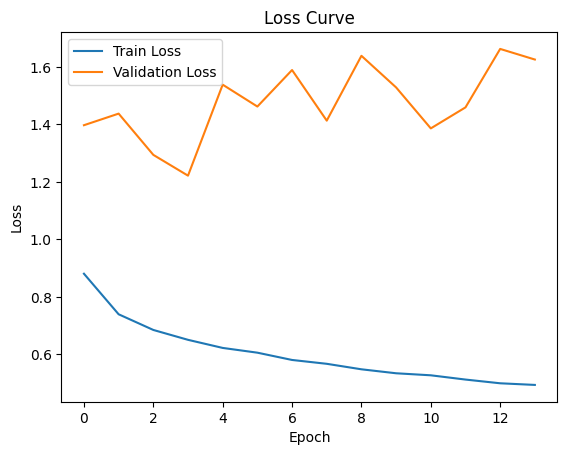

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# --------------------------------------------
# 1. 데이터 로드
# --------------------------------------------

train_df = pd.read_csv('./finalData/InCheon_04.csv')
test_df = pd.read_csv('./finalData/InCheon_05.csv')

# --------------------------------------------
# 2. 입력/출력 컬럼 설정
# --------------------------------------------

input_cols = ['salt', 'wind_dir', 'temp', 'sea_dir_s', 'sea_dir_i', 'sea_temp']
output_cols = ['sea_high', 'wind_speed', 'pressure', 'sea_speed']

# 문자열 컬럼 인코딩
train_df['sea_dir_s'] = train_df['sea_dir_s'].astype('category').cat.codes
test_df['sea_dir_s'] = test_df['sea_dir_s'].astype('category').cat.codes

X_train = train_df[input_cols]
y_train = train_df[output_cols]

X_test = test_df[input_cols]
y_test = test_df[output_cols]

# --------------------------------------------
# 3. 스케일링
# --------------------------------------------

X_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

# --------------------------------------------
# 4. 모델 정의
# --------------------------------------------

model = Sequential()
model.add(Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(y_train_scaled.shape[1], activation='linear'))

model.compile(optimizer='adam', loss='mse')

# --------------------------------------------
# 5. 학습
# --------------------------------------------

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_test_scaled, y_test_scaled),
    epochs=200,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# --------------------------------------------
# 6. 예측 & 역변환
# --------------------------------------------

y_pred_scaled = model.predict(X_test_scaled)
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_true = y_test.values

# --------------------------------------------
# 7. 평가지표
# --------------------------------------------

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)

print(f"✅ RMSE: {rmse:.4f}")
print(f"✅ MAE: {mae:.4f}")

# --------------------------------------------
# 8. 학습 곡선 (선택)
# --------------------------------------------

import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Epoch 1/200
135/135 [==============================] - 1s 3ms/step - loss: 0.8866 - val_loss: 1.5389
Epoch 2/200
135/135 [==============================] - 0s 2ms/step - loss: 0.7307 - val_loss: 1.0577
Epoch 3/200
135/135 [==============================] - 0s 2ms/step - loss: 0.6756 - val_loss: 1.1257
Epoch 4/200
135/135 [==============================] - 0s 2ms/step - loss: 0.6392 - val_loss: 1.3063
Epoch 5/200
135/135 [==============================] - 0s 2ms/step - loss: 0.6175 - val_loss: 1.2592
Epoch 6/200
135/135 [==============================] - 0s 2ms/step - loss: 0.5909 - val_loss: 1.3278
Epoch 7/200
135/135 [==============================] - 0s 2ms/step - loss: 0.5824 - val_loss: 1.2832
Epoch 8/200
135/135 [==============================] - 0s 2ms/step - loss: 0.5595 - val_loss: 1.3415
Epoch 9/200
135/135 [==============================] - 0s 2ms/step - loss: 0.5423 - val_loss: 1.3397
Epoch 10/200
135/135 [==============================] - 0s 2ms/step - loss: 0.5347 - val_lo

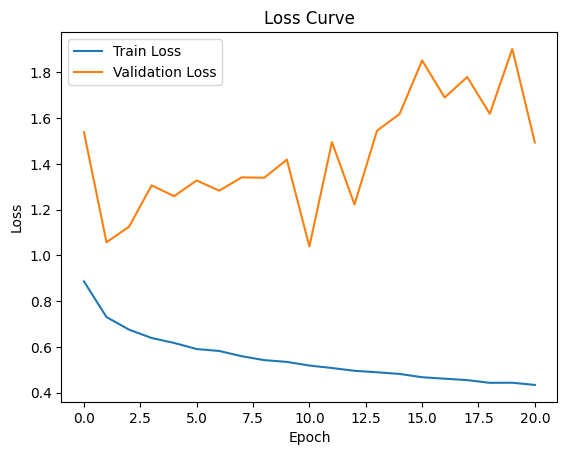

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# --------------------------------------------
# 1. 데이터 로드
# --------------------------------------------

train_df = pd.read_csv('./finalData/InCheon_04.csv')
test_df = pd.read_csv('./finalData/InCheon_05.csv')

# --------------------------------------------
# 2. 입력/출력 컬럼 설정
# --------------------------------------------

input_cols = ['salt', 'wind_dir', 'temp', 'sea_dir_s', 'sea_dir_i', 'sea_temp']
output_cols = ['sea_high', 'wind_speed', 'pressure', 'sea_speed']

# 문자열 컬럼 인코딩
train_df['sea_dir_s'] = train_df['sea_dir_s'].astype('category').cat.codes
test_df['sea_dir_s'] = test_df['sea_dir_s'].astype('category').cat.codes

X_train = train_df[input_cols]
y_train = train_df[output_cols]

X_test = test_df[input_cols]
y_test = test_df[output_cols]

# --------------------------------------------
# 3. 스케일링
# --------------------------------------------

X_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

# --------------------------------------------
# 4. 모델 정의
# --------------------------------------------

model = Sequential()
model.add(Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(y_train_scaled.shape[1], activation='linear'))

model.compile(optimizer='adam', loss='mse')

# --------------------------------------------
# 5. 학습
# --------------------------------------------

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_test_scaled, y_test_scaled),
    epochs=200,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# --------------------------------------------
# 6. 예측 & 역변환
# --------------------------------------------

y_pred_scaled = model.predict(X_test_scaled)
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_true = y_test.values

# --------------------------------------------
# 7. 평가지표: 컬럼별 RMSE & MAE + 전체
# --------------------------------------------

metrics = {}
for i, col in enumerate(output_cols):
    rmse_col = np.sqrt(mean_squared_error(y_true[:, i], y_pred[:, i]))
    mae_col = mean_absolute_error(y_true[:, i], y_pred[:, i])
    metrics[col] = {'RMSE': rmse_col, 'MAE': mae_col}

overall_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
overall_mae = mean_absolute_error(y_true, y_pred)

print("\n✅ 컬럼별 RMSE / MAE")
for col, m in metrics.items():
    print(f"{col}: RMSE={m['RMSE']:.4f}, MAE={m['MAE']:.4f}")

print(f"\n✅ 전체 평균 RMSE: {overall_rmse:.4f}")
print(f"✅ 전체 평균 MAE: {overall_mae:.4f}")

# --------------------------------------------
# 8. 학습 곡선
# --------------------------------------------

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('./finalData/Taean_06.csv', encoding='cp949')
df = df.drop(columns=['datetime','sea_dir_s'])
corr = df.corr()

sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

ValueError: could not convert string to float: '-'

In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# 1. 데이터 로드
train_df = pd.read_csv('./finalData/InCheon_04.csv')
test_df = pd.read_csv('./finalData/InCheon_05.csv')

# 2. 입력/출력 컬럼 설정
input_cols = ['sea_high', 'salt', 'wind_speed', 'wind_dir', 'temp', 'pressure',
              'sea_speed', 'sea_dir_s', 'sea_dir_i', 'sea_temp']
output_cols = ['sea_high','wind_speed','pressure','sea_speed']

# 문자열 컬럼 인코딩 (방향계열만)
for col in ['wind_dir', 'sea_dir_s', 'sea_dir_i']:
    train_df[col] = train_df[col].astype('category').cat.codes
    test_df[col] = test_df[col].astype('category').cat.codes

X_train = train_df[input_cols]
X_test = test_df[input_cols]

# 3. 연속형 컬럼을 3분류(3구간) 카테고리로 변환하는 함수
def to_categories(series, bins=4):
    labels = range(bins)
    # 빈 구간이 안생기도록 include_lowest=True 적용
    cat = pd.cut(series, bins=bins, labels=labels, include_lowest=True)
    return cat.astype(int)

# 4. y를 범주형으로 변환 및 원-핫 인코딩
y_train_cat = pd.DataFrame()
y_test_cat = pd.DataFrame()
bins_num = 4

for col in output_cols:
    y_train_cat[col] = to_categories(train_df[col], bins=bins_num)
    y_test_cat[col] = to_categories(test_df[col], bins=bins_num)

# 각각 원-핫 인코딩
y_train_oh = {}
y_test_oh = {}
for col in output_cols:
    y_train_oh[col] = to_categorical(y_train_cat[col], num_classes=bins_num)
    y_test_oh[col] = to_categorical(y_test_cat[col], num_classes=bins_num)

# 5. 입력 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 6. 모델 정의 (단일 출력 예: sea_high)
# 다중출력 분류모델은 복잡하므로 여기서는 예시로 sea_high만 학습해볼게
model = Sequential()
model.add(Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(bins_num, activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train_oh,
    validation_data=(X_test_scaled, y_test_oh),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=2
)

# 7. 예측 및 평가
y_pred_prob = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_oh, axis=1)

print("\n=== sea_high 분류 성능 ===")
print(classification_report(y_true, y_pred))
print("정확도 (accuracy):", accuracy_score(y_true, y_pred))

# 8. 학습 곡선 시각화
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve (sea_high 분류)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Epoch 1/100


ValueError: in user code:

    File "c:\Users\kosmo\.conda\envs\myvenv3.9\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\kosmo\.conda\envs\myvenv3.9\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\kosmo\.conda\envs\myvenv3.9\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\kosmo\.conda\envs\myvenv3.9\lib\site-packages\keras\engine\training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\kosmo\.conda\envs\myvenv3.9\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "c:\Users\kosmo\.conda\envs\myvenv3.9\lib\site-packages\keras\engine\compile_utils.py", line 236, in __call__
        y_true = self._conform_to_outputs(y_pred, y_true)
    File "c:\Users\kosmo\.conda\envs\myvenv3.9\lib\site-packages\keras\engine\compile_utils.py", line 60, in _conform_to_outputs
        struct = map_to_output_names(outputs, self._output_names, struct)
    File "c:\Users\kosmo\.conda\envs\myvenv3.9\lib\site-packages\keras\engine\compile_utils.py", line 805, in map_to_output_names
        raise ValueError(

    ValueError: Found unexpected losses or metrics that do not correspond to any Model output: dict_keys(['sea_high', 'wind_speed', 'pressure', 'sea_speed']). Valid mode output names: ['dense_13']. Received struct is: {'sea_high': <tf.Tensor 'IteratorGetNext:2' shape=(32, 4) dtype=float32>, 'wind_speed': <tf.Tensor 'IteratorGetNext:4' shape=(32, 4) dtype=float32>, 'pressure': <tf.Tensor 'IteratorGetNext:1' shape=(32, 4) dtype=float32>, 'sea_speed': <tf.Tensor 'IteratorGetNext:3' shape=(32, 4) dtype=float32>}.


Epoch 1/100
135/135 [==============================] - 3s 8ms/step - loss: 4.7902 - sea_high_loss: 1.2043 - wind_speed_loss: 1.1156 - pressure_loss: 1.2850 - sea_speed_loss: 1.1852 - sea_high_accuracy: 0.5035 - wind_speed_accuracy: 0.5630 - pressure_accuracy: 0.4931 - sea_speed_accuracy: 0.5174 - val_loss: 4.6273 - val_sea_high_loss: 1.1695 - val_wind_speed_loss: 1.0569 - val_pressure_loss: 1.2510 - val_sea_speed_loss: 1.1499 - val_sea_high_accuracy: 0.5623 - val_wind_speed_accuracy: 0.6570 - val_pressure_accuracy: 0.4415 - val_sea_speed_accuracy: 0.4769
Epoch 2/100
135/135 [==============================] - 1s 4ms/step - loss: 2.9714 - sea_high_loss: 0.7878 - wind_speed_loss: 0.6453 - pressure_loss: 0.7668 - sea_speed_loss: 0.7714 - sea_high_accuracy: 0.6711 - wind_speed_accuracy: 0.7755 - pressure_accuracy: 0.7072 - sea_speed_accuracy: 0.6831 - val_loss: 3.8558 - val_sea_high_loss: 0.9506 - val_wind_speed_loss: 0.7808 - val_pressure_loss: 1.2863 - val_sea_speed_loss: 0.8381 - val_sea

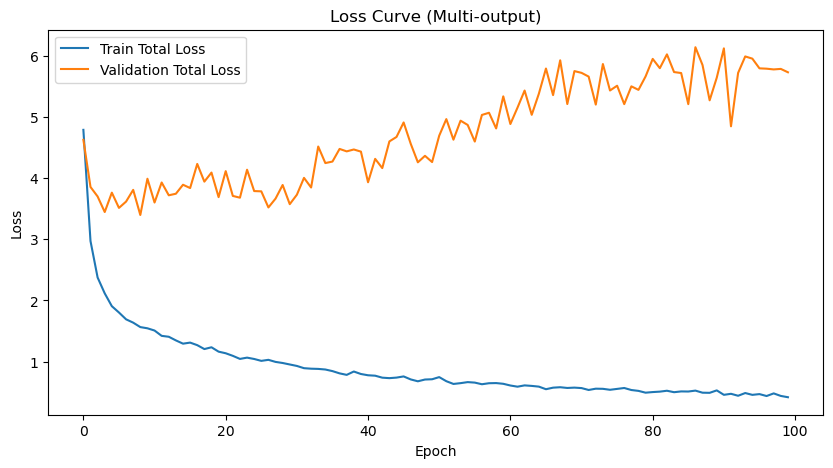

In [21]:
# ===============================================
# 📦 0) 라이브러리
# ===============================================
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# ===============================================
# 1️⃣ 데이터 로드 & 전처리
# ===============================================
train_df = pd.read_csv('./finalData/InCheon_04.csv')
test_df = pd.read_csv('./finalData/InCheon_05.csv')

input_cols = ['sea_high', 'salt', 'wind_speed', 'wind_dir', 'temp', 'pressure',
              'sea_speed', 'sea_dir_s', 'sea_dir_i', 'sea_temp']

output_cols = ['sea_high', 'wind_speed', 'pressure', 'sea_speed']



# 문자열 컬럼 인코딩
for col in [ 'sea_dir_s']:
    train_df[col] = train_df[col].astype('category').cat.codes
    test_df[col] = test_df[col].astype('category').cat.codes

X_train = train_df[input_cols]
X_test = test_df[input_cols]

# 연속형 → 4구간 분류
def to_categories(series, bins=4):
    labels = range(bins)
    cat = pd.cut(series, bins=bins, labels=labels, include_lowest=True)
    return cat.astype(int)

bins_num = 4
# y_train_cat, y_test_cat = {}, {}

# for col in output_cols:
#     y_train_cat[col] = to_categorical(to_categories(train_df[col], bins=bins_num), num_classes=bins_num)
#     y_test_cat[col] = to_categorical(to_categories(test_df[col], bins=bins_num), num_classes=bins_num)

# 스케일링
scaler = StandardScaler()

# log 변환 실험해보고 싶다면:
train_df['wind_speed'] = np.log1p(train_df['wind_speed'])
test_df['wind_speed'] = np.log1p(test_df['wind_speed'])

# 그리고 나서 StandardScaler 적용!
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ===============================================
# 2️⃣ 다중 출력 분류 모델 (Functional API)
# ===============================================
inputs = Input(shape=(X_train_scaled.shape[1],))

x = Dense(256, activation='relu')(inputs)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Dense(32, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

# 출력층 분기
outputs = []
for col in output_cols:
    out = Dense(bins_num, activation='softmax', name=col)(x)
    outputs.append(out)

model = Model(inputs=inputs, outputs=outputs)

losses = {col: 'categorical_crossentropy' for col in output_cols}
metrics = {col: 'accuracy' for col in output_cols}

model.compile(
    optimizer=Adam(),
    loss=losses,
    metrics=metrics
)

# model.summary()

# ===============================================
# 3️⃣ 학습
# ===============================================
# early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_scaled,
    [y_train_cat[col] for col in output_cols],
    validation_data=(X_test_scaled, [y_test_cat[col] for col in output_cols]),
    epochs=100,
    batch_size=32,
    verbose=1
)

# ===============================================
# 4️⃣ 예측 & 평가
# ===============================================
y_pred_probs = model.predict(X_test_scaled)

for i, col in enumerate(output_cols):
    y_true = np.argmax(y_test_cat[col], axis=1)
    y_pred = np.argmax(y_pred_probs[i], axis=1)
    
    print(f"\n=== [{col}] 분류 성능 ===")
    print(classification_report(y_true, y_pred))
    print("정확도:", accuracy_score(y_true, y_pred))

# ===============================================
# 5️⃣ Loss Curve
# ===============================================
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Total Loss')
plt.plot(history.history['val_loss'], label='Validation Total Loss')
plt.title('Loss Curve (Multi-output)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


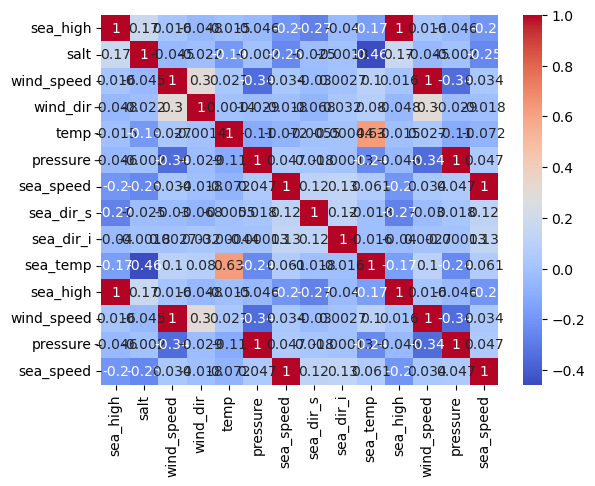

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = train_df[input_cols + output_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()


--- [sea_high] 모델 학습 시작 ---
Epoch 1/100
68/68 - 2s - loss: 0.7525 - accuracy: 0.6903 - val_loss: 1.0836 - val_accuracy: 0.5829 - 2s/epoch - 25ms/step
Epoch 2/100
68/68 - 0s - loss: 0.3944 - accuracy: 0.8317 - val_loss: 0.9771 - val_accuracy: 0.5195 - 217ms/epoch - 3ms/step
Epoch 3/100
68/68 - 0s - loss: 0.3117 - accuracy: 0.8738 - val_loss: 1.0333 - val_accuracy: 0.4834 - 216ms/epoch - 3ms/step
Epoch 4/100
68/68 - 0s - loss: 0.2703 - accuracy: 0.8884 - val_loss: 0.8902 - val_accuracy: 0.6250 - 200ms/epoch - 3ms/step
Epoch 5/100
68/68 - 0s - loss: 0.2542 - accuracy: 0.8944 - val_loss: 0.7346 - val_accuracy: 0.6924 - 222ms/epoch - 3ms/step
Epoch 6/100
68/68 - 0s - loss: 0.2267 - accuracy: 0.9046 - val_loss: 0.3987 - val_accuracy: 0.8459 - 207ms/epoch - 3ms/step
Epoch 7/100
68/68 - 0s - loss: 0.2284 - accuracy: 0.9019 - val_loss: 0.3099 - val_accuracy: 0.8676 - 210ms/epoch - 3ms/step
Epoch 8/100
68/68 - 0s - loss: 0.2081 - accuracy: 0.9130 - val_loss: 0.4825 - val_accuracy: 0.8230 - 205m

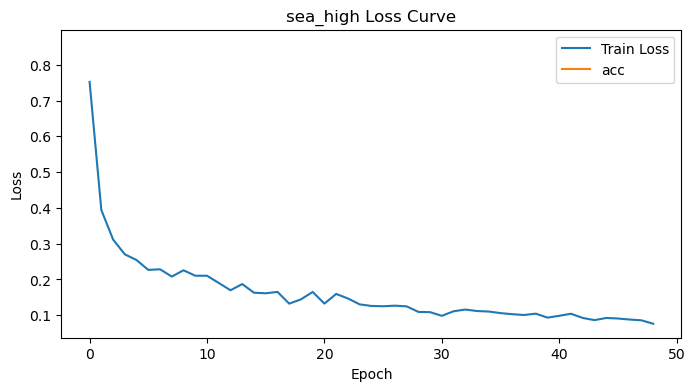

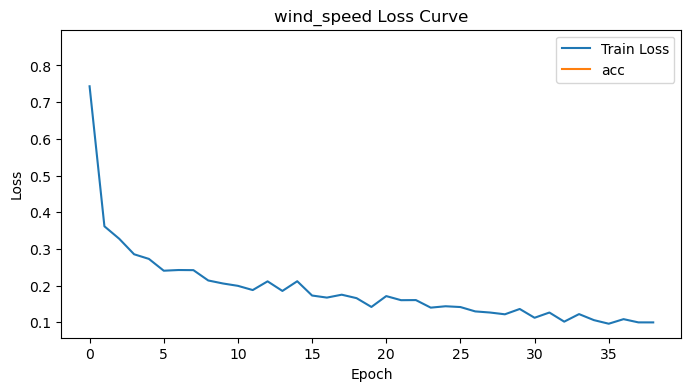

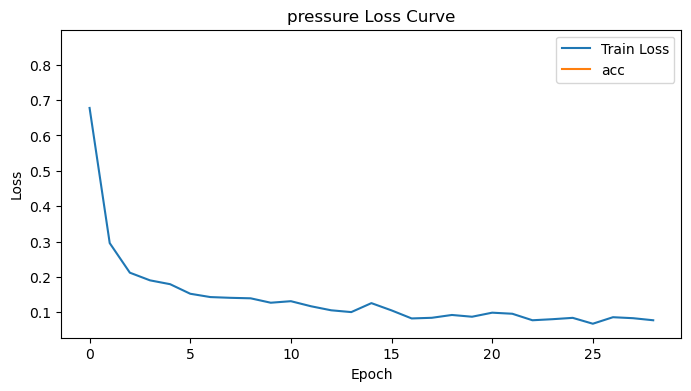

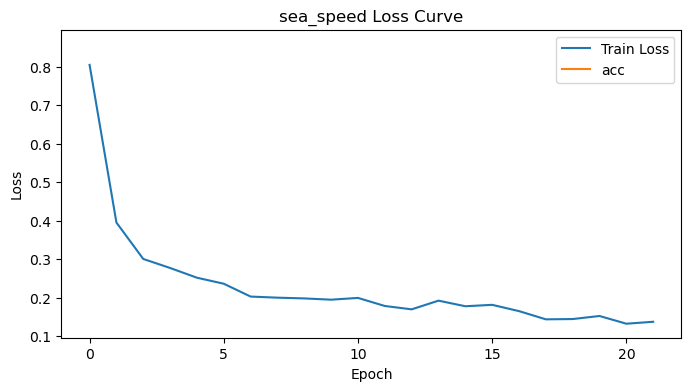

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# 1. 데이터 로드
train_df = pd.read_csv('./finalData/InCheon_04.csv')
test_df = pd.read_csv('./finalData/InCheon_05.csv')

input_cols = ['sea_high', 'salt', 'wind_speed', 'wind_dir', 'temp', 'pressure',
              'sea_speed', 'sea_dir_s', 'sea_dir_i', 'sea_temp']
output_cols = ['sea_high', 'wind_speed', 'pressure', 'sea_speed']

bins_num = 3

# 2. 방향 컬럼 라벨 인코딩 (train/test 통합해서 같은 인코딩 보장)
for col in ['wind_dir', 'sea_dir_s', 'sea_dir_i']:
    combined = pd.concat([train_df[col], test_df[col]], axis=0)
    categories = combined.astype('category').cat.categories
    train_df[col] = train_df[col].astype(pd.api.types.CategoricalDtype(categories=categories)).cat.codes
    test_df[col] = test_df[col].astype(pd.api.types.CategoricalDtype(categories=categories)).cat.codes

X_train = train_df[input_cols]
X_test = test_df[input_cols]

# 3. 구간 나누기 함수 (분포별 커스텀 조정 가능)
def to_categories(series, bins=bins_num):
    labels = range(bins)
    try:
        cat = pd.qcut(series, q=bins, labels=labels, duplicates='drop')
        # 만약 qcut 후 고르게 안나누어졌으면 cut으로 fallback (예: 분포 치우침)
        if cat.isnull().any():
            cat = pd.cut(series, bins=bins, labels=labels, include_lowest=True)
    except Exception:
        cat = pd.cut(series, bins=bins, labels=labels, include_lowest=True)
    return cat.astype(int)

# 4. y 데이터 카테고리화 + 원-핫 인코딩
y_train_cat = pd.DataFrame()
y_test_cat = pd.DataFrame()
for col in output_cols:
    y_train_cat[col] = to_categories(train_df[col], bins=bins_num)
    y_test_cat[col] = to_categories(test_df[col], bins=bins_num)

y_train_oh = {}
y_test_oh = {}
for col in output_cols:
    y_train_oh[col] = to_categorical(y_train_cat[col], num_classes=bins_num)
    y_test_oh[col] = to_categorical(y_test_cat[col], num_classes=bins_num)

# 5. 입력 스케일링: RobustScaler로 이상치 영향 줄임
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 6. 모델 생성 함수 (BatchNormalization 추가, Dropout 감소)
def build_model(input_dim, output_dim):
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.2),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(output_dim, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

results = {}

# 7. 변수별 모델 학습 및 평가
for col in output_cols:
    print(f'\n--- [{col}] 모델 학습 시작 ---')
    
    input_dim = X_train_scaled.shape[1]
    output_dim = y_train_oh[col].shape[1]

    class_weights = compute_class_weight(class_weight='balanced',
                                         classes=np.unique(y_train_cat[col]),
                                         y=y_train_cat[col])
    class_weight_dict = dict(enumerate(class_weights))

    model = build_model(input_dim, output_dim)
    early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

    history = model.fit(
        X_train_scaled, y_train_oh[col],
        validation_data=(X_test_scaled, y_test_oh[col]),
        epochs=100,
        batch_size=64,
        class_weight=class_weight_dict,
        callbacks=[early_stop],
        verbose=2
    )
    
    y_pred_probs = model.predict(X_test_scaled)
    y_pred_labels = np.argmax(y_pred_probs, axis=1)
    y_true_labels = np.argmax(y_test_oh[col], axis=1)

    acc = accuracy_score(y_true_labels, y_pred_labels)
    print(f"\n[{col}] 분류 정확도: {acc:.4f}")
    print(classification_report(y_true_labels, y_pred_labels))
    
    results[col] = {
        'accuracy': acc,
        'classification_report': classification_report(y_true_labels, y_pred_labels),
        'history': history
    }
    model.save(f'./model/{col}_mlp_model.h5')
    


# 8. 학습 곡선 시각화
for col in output_cols:
    hist = results[col]['history']
    plt.figure(figsize=(8,4))
    plt.plot(hist.history['loss'], label='Train Loss')
    plt.plot(acc, label='acc')
    plt.title(f'{col} Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


✅ 시계열 shape: (4314, 6, 10)
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 6, 10)]      0           []                               
                                                                                                  
 lstm_1 (LSTM)                  (None, 128)          71168       ['input_5[0][0]']                
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 128)         512         ['lstm_1[0][0]']                 
 rmalization)                                                                                     
                                                                                                  
 dropout_19 (Dropout)           (None, 128)          0           

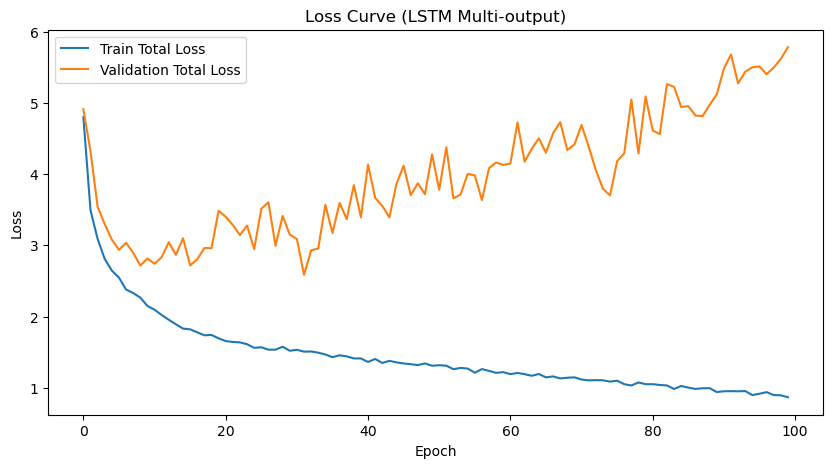

In [17]:
# ===============================================
# 📦 0) 라이브러리
# ===============================================
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# ===============================================
# 1️⃣ 데이터 로드 & 전처리
# ===============================================
train_df = pd.read_csv('./finalData/InCheon_04.csv')
test_df = pd.read_csv('./finalData/InCheon_05.csv')

input_cols = ['sea_high', 'salt', 'wind_speed', 'wind_dir', 'temp', 'pressure',
              'sea_speed', 'sea_dir_s', 'sea_dir_i', 'sea_temp']

output_cols = ['sea_high', 'wind_speed', 'pressure', 'sea_speed']

# 문자열 컬럼 인코딩
for col in ['wind_dir', 'sea_dir_s', 'sea_dir_i']:
    train_df[col] = train_df[col].astype('category').cat.codes
    test_df[col] = test_df[col].astype('category').cat.codes

X_train = train_df[input_cols]
X_test = test_df[input_cols]

# 연속형 → 4구간 분류
def to_categories(series, bins=4):
    labels = range(bins)
    cat = pd.qcut(series, q=bins, labels=labels)  # ✅ qcut로 균등 분할 추천
    return cat.astype(int)

bins_num = 4
y_train_cat, y_test_cat = {}, {}

for col in output_cols:
    y_train_cat[col] = to_categorical(to_categories(train_df[col], bins=bins_num), num_classes=bins_num)
    y_test_cat[col] = to_categorical(to_categories(test_df[col], bins=bins_num), num_classes=bins_num)

# 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ===============================================
# 2️⃣ 슬라이딩 윈도우 시계열로 변환
# ===============================================
def create_sequences(X, y_dict, window_size):
    Xs = []
    ys = {col: [] for col in y_dict.keys()}

    for i in range(len(X) - window_size):
        Xs.append(X[i:(i + window_size)])
        for col in y_dict.keys():
            ys[col].append(y_dict[col][i + window_size])

    Xs = np.array(Xs)
    ys = {col: np.array(ys[col]) for col in y_dict.keys()}
    return Xs, ys

window_size = 6  # 예: 최근 6시간

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_cat, window_size)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_cat, window_size)

print("✅ 시계열 shape:", X_train_seq.shape)

# ===============================================
# 3️⃣ LSTM 다중 출력 모델 (Functional)
# ===============================================
inputs = Input(shape=(window_size, X_train_seq.shape[2]))

x = LSTM(128, return_sequences=False)(inputs)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Dense(32, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

outputs = []
for col in output_cols:
    out = Dense(bins_num, activation='softmax', name=col)(x)
    outputs.append(out)

model = Model(inputs=inputs, outputs=outputs)

losses = {col: 'categorical_crossentropy' for col in output_cols}
metrics = {col: 'accuracy' for col in output_cols}

model.compile(
    optimizer=Adam(),
    loss=losses,
    metrics=metrics
)

model.summary()

# ===============================================
# 4️⃣ 학습
# ===============================================
# early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_seq,
    [y_train_seq[col] for col in output_cols],
    validation_data=(X_test_seq, [y_test_seq[col] for col in output_cols]),
    epochs=100,
    batch_size=32,
    verbose=1
)

# ===============================================
# 5️⃣ 예측 & 평가
# ===============================================
y_pred_probs = model.predict(X_test_seq)

for i, col in enumerate(output_cols):
    y_true = np.argmax(y_test_seq[col], axis=1)
    y_pred = np.argmax(y_pred_probs[i], axis=1)
    
    print(f"\n=== [{col}] LSTM 분류 성능 ===")
    print(classification_report(y_true, y_pred))
    print("정확도:", accuracy_score(y_true, y_pred))

# ===============================================
# 6️⃣ Loss Curve
# ===============================================
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Total Loss')
plt.plot(history.history['val_loss'], label='Validation Total Loss')
plt.title('Loss Curve (LSTM Multi-output)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Epoch 1/100
135/135 - 4s - loss: 7.3703 - sea_high_loss: 0.8436 - salt_loss: 0.3177 - wind_speed_loss: 0.5991 - wind_dir_loss: 0.9995 - temp_loss: 0.8268 - pressure_loss: 0.8239 - sea_speed_loss: 0.8477 - sea_dir_s_loss: 0.6305 - sea_dir_i_loss: 0.7061 - sea_temp_loss: 0.7755 - sea_high_accuracy: 0.5935 - salt_accuracy: 0.9292 - wind_speed_accuracy: 0.7685 - wind_dir_accuracy: 0.4755 - temp_accuracy: 0.6009 - pressure_accuracy: 0.6333 - sea_speed_accuracy: 0.5896 - sea_dir_s_accuracy: 0.7604 - sea_dir_i_accuracy: 0.6938 - sea_temp_accuracy: 0.6512 - val_loss: 14.5005 - val_sea_high_loss: 1.0229 - val_salt_loss: 2.2570 - val_wind_speed_loss: 0.6783 - val_wind_dir_loss: 1.2370 - val_temp_loss: 1.9867 - val_pressure_loss: 2.0219 - val_sea_speed_loss: 0.6799 - val_sea_dir_s_loss: 0.2937 - val_sea_dir_i_loss: 0.3793 - val_sea_temp_loss: 3.9438 - val_sea_high_accuracy: 0.5314 - val_salt_accuracy: 0.8855 - val_wind_speed_accuracy: 0.6794 - val_wind_dir_accuracy: 0.4718 - val_temp_accuracy: 0.

c:\Users\kosmo\.conda\envs\myvenv3.9\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\kosmo\.conda\envs\myvenv3.9\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\kosmo\.conda\envs\myvenv3.9\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\U

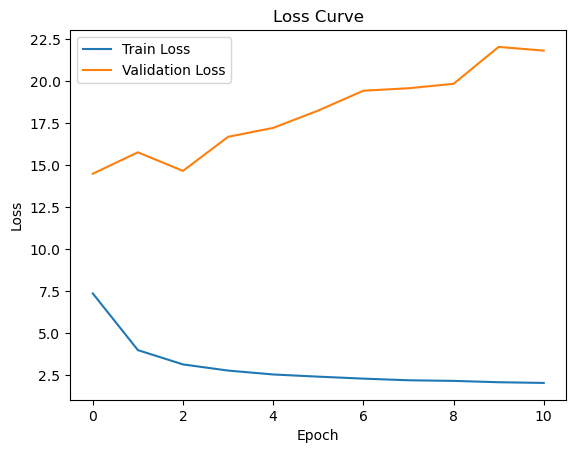

In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# 1. 데이터 로드
train_df = pd.read_csv('./finalData/InCheon_04.csv')
test_df = pd.read_csv('./finalData/InCheon_05.csv')

# 2. 입력/출력 컬럼 설정
input_cols = ['sea_high', 'salt', 'wind_speed', 'wind_dir', 'temp', 'pressure',
              'sea_speed', 'sea_dir_s', 'sea_dir_i', 'sea_temp']
output_cols = input_cols.copy()
bins_num = 3  # 3분류

# 3. 방향 컬럼 인코딩
for col in ['wind_dir', 'sea_dir_s', 'sea_dir_i']:
    train_df[col] = train_df[col].astype('category').cat.codes
    test_df[col] = test_df[col].astype('category').cat.codes

X_train = train_df[input_cols]
X_test = test_df[input_cols]

# 4. 연속형 컬럼 -> 3분류 카테고리 변환 함수
def to_categories(series, bins=3):
    labels = range(bins)
    cat = pd.cut(series, bins=bins, labels=labels, include_lowest=True)
    return cat.astype(int)

# 5. y 카테고리화 및 원-핫 인코딩 준비
y_train_cat = {}
y_test_cat = {}
y_train_oh = {}
y_test_oh = {}

for col in output_cols:
    y_train_cat[col] = to_categories(train_df[col], bins=bins_num)
    y_test_cat[col] = to_categories(test_df[col], bins=bins_num)
    y_train_oh[col] = to_categorical(y_train_cat[col], num_classes=bins_num)
    y_test_oh[col] = to_categorical(y_test_cat[col], num_classes=bins_num)

# 6. 입력 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 7. 다중출력 모델 설계
inputs = Input(shape=(X_train_scaled.shape[1],))
x = Dense(128, activation='relu')(inputs)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)

outputs = []
for col in output_cols:
    out = Dense(bins_num, activation='softmax', name=col)(x)
    outputs.append(out)

model = Model(inputs=inputs, outputs=outputs)

# 8. 컴파일: 각 출력마다 loss 지정
losses = {col: 'categorical_crossentropy' for col in output_cols}
metrics = {col: 'accuracy' for col in output_cols}

model.compile(optimizer=Adam(), loss=losses, metrics=metrics)

# 9. 학습
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_scaled,
    [y_train_oh[col] for col in output_cols],
    validation_data=(X_test_scaled, [y_test_oh[col] for col in output_cols]),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=2
)

# 10. 평가: 각 컬럼별 정확도 출력 및 classification report
print("\n=== 다중 출력 분류 결과 ===")
y_pred = model.predict(X_test_scaled)
for i, col in enumerate(output_cols):
    y_pred_label = np.argmax(y_pred[i], axis=1)
    y_true_label = np.argmax(y_test_oh[col], axis=1)
    acc = accuracy_score(y_true_label, y_pred_label)
    print(f"[{col}] 정확도: {acc:.4f}")
    print(classification_report(y_true_label, y_pred_label))

# 11. 학습 곡선 그리기 (Train/Val loss는 합산된 값)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
